In [1]:
# 1.0 - TensorFlow model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from imutils import paths
import h5py
import numpy as np
import argparse
import imutils
import cv2
import os
import math
import matplotlib.pyplot as plt
import scipy
from random import shuffle
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K
from keras import optimizers
#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


In [ ]:
# Mount data from google drive    
# Dataset to be imported below:
#from google.colab import drive
#drive.mount('/content/gdrive')


In [2]:
#Load Datasets
#X_data = h5py.File('/content/gdrive/Team Drives/CS 230 Project/Cereal pics/X_data.h5', 'r')
#Y_data = h5py.File('/content/gdrive/Team Drives/CS 230 Project/Cereal pics/Y_data.h5', 'r')
  
X_data = h5py.File('X_data.h5', 'r')
Y_data = h5py.File('Y_data.h5', 'r')
  
#Specify Split ratios
Train_percent = 0.97
Dev_percent = 0.0
Test_percent = 0.03

#Get shapes of data:
m = len(X_data)
h_X,w_X,c_X = np.shape(X_data['X1'])

#Get indices of train/dev/test split
temp_list = list(range(m))
shuffle(temp_list)
Train_list = temp_list[0:int(Train_percent*m)]
Dev_list = temp_list[int(Train_percent*m):int(Train_percent*m)+int(Dev_percent*m)]
Test_list = temp_list[int(Train_percent*m)+int(Dev_percent*m):
                      int(Train_percent*m)+int(Dev_percent*m)+int(Test_percent*m)]

# Create np arrays for train/dev/test set
X_train_orig = np.empty((len(Train_list),h_X,w_X,c_X))
Y_train_orig = np.empty(len(Train_list))
X_dev_orig = np.empty((len(Dev_list),h_X,w_X,c_X))
Y_dev_orig = np.empty(len(Dev_list))
X_test_orig = np.empty((len(Test_list),h_X,w_X,c_X))
Y_test_orig = np.empty(len(Test_list))

#Copy data from dataset onto the np arrays
for ind,item in enumerate(Train_list):
    X_train_orig[ind]=X_data['X'+str(item)][:]
    Y_train_orig[ind]=Y_data['y'+str(item)][:]
for ind,item in enumerate(Dev_list):
    X_dev_orig[ind]=X_data['X'+str(item)][:]
    Y_dev_orig[ind]=Y_data['y'+str(item)][:]
for ind,item in enumerate(Test_list):
    X_test_orig[ind]=X_data['X'+str(item)][:]
    Y_test_orig[ind]=Y_data['y'+str(item)][:]

print("Done building dataset")
    
  

Done building dataset


In [3]:
# To get started, let's examine the shapes of your data.
X_train = np.reshape(X_train_orig/255.,(X_train_orig.shape[0],256*256*3),order='C')
X_dev = np.reshape(X_dev_orig/255.,(X_dev_orig.shape[0],256*256*3),order='C')
X_test = np.reshape(X_test_orig/255.,(X_test_orig.shape[0],256*256*3),order='C')
Y_train = Y_train_orig
Y_dev = Y_dev_orig
Y_test = Y_test_orig
X_train_orig, X_dev_orig, X_test_orig = None, None, None
Y_train_orig, Y_dev_orig, Y_test_orig = None, None, None
del X_data
del Y_data
X_train = scale(X_train)
X_test = scale(X_test)
pca = PCA()
pca.fit(X_train)
pca.fit(X_test)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 8652
number of dev examples = 0
number of test examples = 267
X_train shape: (8652, 196608)
Y_train shape: (8652,)
X_dev shape: (0, 196608)
Y_dev shape: (0,)
X_test shape: (267, 196608)
Y_test shape: (267,)


In [ ]:
# Define the Model and Network Architecture

# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 1)
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

# fitting the model
knn.fit(X_train, Y_train)

In [ ]:
# predict the response
pred = knn.predict(X_test)

In [ ]:
# evaluate accuracy
print(accuracy_score(Y_test, pred))
print(classification_report(Y_test, pred))

In [ ]:
# creating odd list of K for KNN
myList = list(range(1,20))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(k)


1
3
5
7
9


[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
The optimal number of neighbors is 1


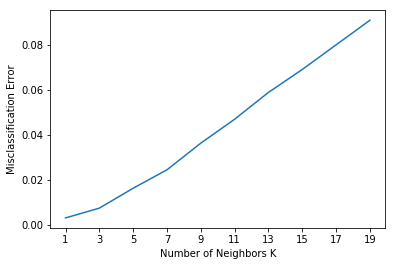

In [18]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# creating odd list of K for KNN
myList = list(range(1,20))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)
neighbors_l = []
for k in neighbors:
    neighbors_l.append(k)
print(neighbors_l)
# determining best k
optimal_k = neighbors_l[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors_l, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.xticks(np.arange(1, 20, step=2))
plt.show()



In [ ]:
np.argmax(pred[0])
plt.imshow(X_test[0])